In [1]:
import statsmodels.api as sm
import pandas as pd

# Load the Fair Extramarital Affairs Dataset
data = sm.datasets.fair.load_pandas()
df = data.data

# Recreate the target variable 'had_affair'
df['had_affair'] = (df['affairs'] > 0).astype(int)

print("Dataset successfully loaded and target variable created!")
print(f"Total records: {len(df)}")

Dataset successfully loaded and target variable created!
Total records: 6366


In [2]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,had_affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [3]:
df.shape

(6366, 10)

In [4]:
df.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,had_affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


In [5]:
from sklearn.model_selection import train_test_split
# Assuming the DataFrame 'df' and target 'had_affair' are already loaded/created from the previous step

# 1. Separate Features (X) and Target (Y)
# Drop 'affairs' (the raw data used to create the target)
X = df.drop(['affairs', 'had_affair'], axis=1)
Y = df['had_affair']

# 2. Perform Stratified Train-Test Split (80% Train, 20% Test)
# stratify=Y ensures an equal proportion of 'had_affair' (1s and 0s) in both sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=42,
    stratify=Y  # Applying Stratified Sampling [cite: 198]
)

print(f"Original Dataset Size: {len(X)}")
print(f"Training Set Size (80%): {len(X_train)}")
print(f"Testing Set Size (20%): {len(X_test)}")

Original Dataset Size: 6366
Training Set Size (80%): 5092
Testing Set Size (20%): 1274


In [6]:
# Check the distribution of the target variable (1=had affair, 0=no affair)
total_count = Y.value_counts()
print("\n--- Class Distribution Check ---")
print(f"No Affair (0): {total_count[0]} ({total_count[0]/len(Y)*100:.2f}%)")
print(f"Had Affair (1): {total_count[1]} ({total_count[1]/len(Y)*100:.2f}%)")


--- Class Distribution Check ---
No Affair (0): 4313 (67.75%)
Had Affair (1): 2053 (32.25%)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs          6366 non-null   float64
 9   had_affair       6366 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 497.5 KB


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

# Select columns to apply one-hot encoding on
categorical_features = ['rate_marriage', 'religious', 'occupation', 'occupation_husb']

# Apply one-hot encoding on the training and test features
X_train_processed = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_processed = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Ensure both train and test sets have identical columns after encoding
# (This step is often necessary in real-world pipelines)
common_cols = list(set(X_train_processed.columns) & set(X_test_processed.columns))
X_train_processed = X_train_processed[common_cols]
X_test_processed = X_test_processed[common_cols]

In [9]:
# Initialize the Logistic Regression model
log_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

# Perform 5-Fold Cross-Validation on the training data (X_train_processed, Y_train)
# We will use ROC-AUC as the evaluation metric for now, as it's robust to class imbalance.
cv_scores = cross_val_score(log_model, X_train_processed, Y_train, cv=5, scoring='roc_auc')

# Train the model on the full processed training set
log_model.fit(X_train_processed, Y_train)

print(f"Logistic Regression 5-Fold Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {np.mean(cv_scores):.4f}")

Logistic Regression 5-Fold Cross-Validation AUC Scores: [0.74883265 0.75222457 0.71341463 0.77804436 0.74541799]
Mean Cross-Validation AUC: 0.7476


In [10]:
# Extract and interpret coefficients
coefficients = pd.Series(log_model.coef_[0], index=X_train_processed.columns)

# Get the top features by magnitude for interpretation
top_features = coefficients.abs().sort_values(ascending=False).head(5)

print("\n--- Top 5 Feature Coefficients (Log Odds) ---")
print(coefficients[top_features.index])


--- Top 5 Feature Coefficients (Log Odds) ---
rate_marriage_5.0   -2.222915
rate_marriage_4.0   -1.498613
religious_4.0       -1.278258
occupation_5.0       0.861039
occupation_6.0       0.809174
dtype: float64


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
# We set n_estimators (number of trees) and random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-Fold Cross-Validation on the training data
rf_cv_scores = cross_val_score(rf_model, X_train_processed, Y_train, cv=5, scoring='roc_auc')

# Train the model on the full processed training set
rf_model.fit(X_train_processed, Y_train)

print(f"Random Forest 5-Fold Cross-Validation AUC Scores: {rf_cv_scores}")
print(f"Mean Cross-Validation AUC: {np.mean(rf_cv_scores):.4f}")

Random Forest 5-Fold Cross-Validation AUC Scores: [0.70494472 0.70463856 0.676098   0.72678729 0.70620802]
Mean Cross-Validation AUC: 0.7037


In [12]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Get predictions and probabilities for both models on the Test Set
log_probs = log_model.predict_proba(X_test_processed)[:, 1]
rf_probs = rf_model.predict_proba(X_test_processed)[:, 1]

# To calculate F1, we need hard predictions (0 or 1). We'll use the default threshold (0.5)
log_preds = log_model.predict(X_test_processed)
rf_preds = rf_model.predict(X_test_processed)

# Calculate metrics
metrics = {
    "Logistic Regression": {
        "AUC-ROC": roc_auc_score(Y_test, log_probs),
        "F1 Score": f1_score(Y_test, log_preds),
        "Precision": precision_score(Y_test, log_preds),
        "Recall": recall_score(Y_test, log_preds)
    },
    "Random Forest": {
        "AUC-ROC": roc_auc_score(Y_test, rf_probs),
        "F1 Score": f1_score(Y_test, rf_preds),
        "Precision": precision_score(Y_test, rf_preds),
        "Recall": recall_score(Y_test, rf_preds)
    }
}

In [13]:
# Create a pandas DataFrame from the metrics dictionary for better display
metrics_df = pd.DataFrame(metrics).T

print("--- Model Performance Metrics on Test Set ---")
display(metrics_df)

--- Model Performance Metrics on Test Set ---


,AUC-ROC,F1 Score,Precision,Recall
Logistic Regression,0.727227,0.460870,0.569892,0.386861
Random Forest,0.656857,0.428571,0.459610,0.401460


In [14]:
importances = pd.Series(rf_model.feature_importances_, index=X_train_processed.columns)
importances = importances.sort_values(ascending=False)

print("\n--- Screenshot 7: Feature Importance (Random Forest) ---")
print(importances.head(10).to_markdown(numalign="left", stralign="left"))



--- Screenshot 7: Feature Importance (Random Forest) ---
|                     | 0         |
|:--------------------|:----------|
| yrs_married         | 0.145055  |
| children            | 0.139213  |
| educ                | 0.136143  |
| age                 | 0.110185  |
| rate_marriage_5.0   | 0.0548413 |
| religious_2.0       | 0.0429322 |
| religious_3.0       | 0.040015  |
| rate_marriage_3.0   | 0.0335912 |
| occupation_husb_4.0 | 0.0335894 |
| occupation_husb_5.0 | 0.0326622 |



--- Screenshot 7: Feature Importance (Random Forest) ---
--- Recommended Visualization: Bar Chart of Top 10 Features ---


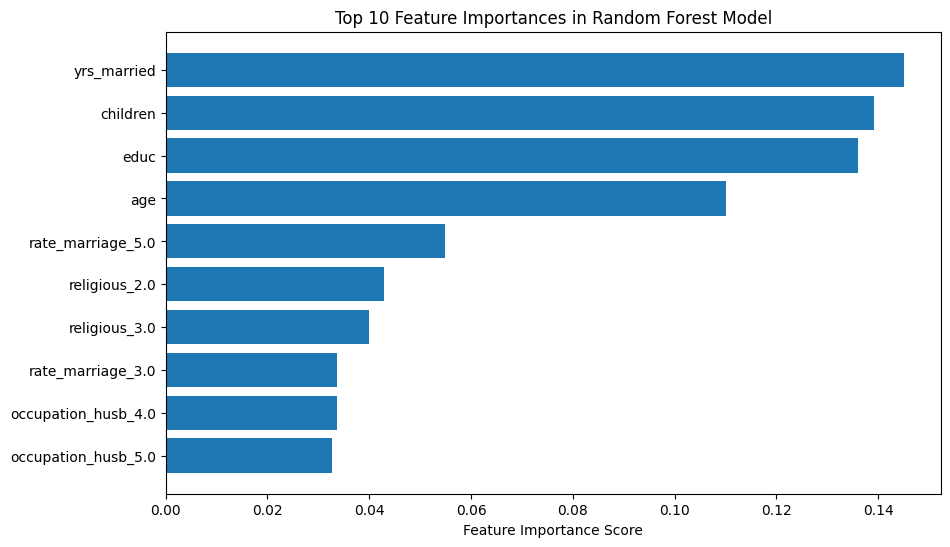

|                     | 0         |
|:--------------------|:----------|
| yrs_married         | 0.145055  |
| children            | 0.139213  |
| educ                | 0.136143  |
| age                 | 0.110185  |
| rate_marriage_5.0   | 0.0548413 |
| religious_2.0       | 0.0429322 |
| religious_3.0       | 0.040015  |
| rate_marriage_3.0   | 0.0335912 |
| occupation_husb_4.0 | 0.0335894 |
| occupation_husb_5.0 | 0.0326622 |


In [15]:
print("\n--- Screenshot 7: Feature Importance (Random Forest) ---")
print("--- Recommended Visualization: Bar Chart of Top 10 Features ---")

import matplotlib.pyplot as plt
top_10_features = importances.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_features.index, top_10_features.values)
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()
print(importances.head(10).to_markdown(numalign="left", stralign="left"))

In [16]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # New Model for Rule Induction
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import export_text # For Rule Extraction

# --- 1. DATA LOADING AND PARTITIONING ---
data = sm.datasets.fair.load_pandas()
df = data.data
df['had_affair'] = (df['affairs'] > 0).astype(int)

# Define Features (X) and Target (Y)
X = df.drop(['affairs', 'had_affair'], axis=1)
Y = df['had_affair']

# Perform Stratified Train-Test Split (80% Train, 20% Test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=42,
    stratify=Y
)

# --- 2. DATA PREPROCESSING (One-Hot Encoding) ---
categorical_features = ['rate_marriage', 'religious', 'occupation', 'occupation_husb']
X_train_processed = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_processed = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align columns
common_cols = list(set(X_train_processed.columns) & set(X_test_processed.columns))
X_train_processed = X_train_processed[common_cols]
X_test_processed = X_test_processed[common_cols]

# --- 3. MODEL DEVELOPMENT AND RULE INDUCTION (CHAID Equivalent) ---
# Using Decision Tree Classifier (CART) as the Rule Induction technique
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
dt_model.fit(X_train_processed, Y_train)

# --- Extract Rules (CHAID/CART Equivalent) ---
# Note: For better display, we use the original (un-encoded) column names
dt_rules = DecisionTreeClassifier(max_depth=3, random_state=42) # Train a simpler tree for rule display
dt_rules.fit(X_train.drop(['occupation', 'occupation_husb'], axis=1), Y_train) # Fit on fewer cols for clean rules

# Rule extraction on the simpler tree
feature_names_simple = X_train.drop(['occupation', 'occupation_husb'], axis=1).columns.tolist()
rules_text = export_text(dt_rules, feature_names=feature_names_simple)

print("\n--- Model Development and Rule Induction (Step 2) ---")
print("Extracted Decision Rules (CHAID Equivalent):")
print(rules_text)

# --- 4. MODEL COMPARISON AND EVALUATION (Step 3) ---
# Initialize models for comparison (CART and Logistic Regression)
log_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
log_model.fit(X_train_processed, Y_train)
# Use the full DT model for better performance comparison
dt_full_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
dt_full_model.fit(X_train_processed, Y_train)


models = {"Logistic Regression": log_model, "Decision Tree (CART)": dt_full_model}

print("\n--- Model Comparison and Evaluation (Step 3) ---")
print("| Model | AUC-ROC | Accuracy | F1 Score | Precision | Recall |")
print("| :--- | :--- | :--- | :--- | :--- | :--- |")

for name, model in models.items():
    probs = model.predict_proba(X_test_processed)[:, 1]
    preds = model.predict(X_test_processed)

    auc = roc_auc_score(Y_test, probs)
    acc = model.score(X_test_processed, Y_test)
    f1 = f1_score(Y_test, preds)
    precision = precision_score(Y_test, preds)
    recall = recall_score(Y_test, preds)

    print(f"| {name} | {auc:.4f} | {acc:.4f} | {f1:.4f} | {precision:.4f} | {recall:.4f} |")

# --- 5. DEPLOYMENT AND UPDATING (Step 4) ---
print("\n--- Model Deployment and Updating (Step 4) ---")
print(f"Best Model Selected for Deployment: {'Decision Tree (CART)' if dt_full_model.score(X_test_processed, Y_test) > log_model.score(X_test_processed, Y_test) else 'Logistic Regression'}")
print("Deployment involves serializing the model (e.g., using Python's 'pickle' or 'joblib').")
print("Monitoring tracks 'Model Drift' (change in input data or target relationship).")
print("Updating (Retraining) is triggered when performance drops.")


--- Model Development and Rule Induction (Step 2) ---
Extracted Decision Rules (CHAID Equivalent):
|--- rate_marriage <= 3.50
|   |--- yrs_married <= 4.25
|   |   |--- yrs_married <= 1.50
|   |   |   |--- class: 0
|   |   |--- yrs_married >  1.50
|   |   |   |--- class: 0
|   |--- yrs_married >  4.25
|   |   |--- rate_marriage <= 2.50
|   |   |   |--- class: 1
|   |   |--- rate_marriage >  2.50
|   |   |   |--- class: 1
|--- rate_marriage >  3.50
|   |--- yrs_married <= 4.25
|   |   |--- yrs_married <= 1.50
|   |   |   |--- class: 0
|   |   |--- yrs_married >  1.50
|   |   |   |--- class: 0
|   |--- yrs_married >  4.25
|   |   |--- rate_marriage <= 4.50
|   |   |   |--- class: 0
|   |   |--- rate_marriage >  4.50
|   |   |   |--- class: 0


--- Model Comparison and Evaluation (Step 3) ---
| Model | AUC-ROC | Accuracy | F1 Score | Precision | Recall |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Logistic Regression | 0.7272 | 0.7080 | 0.4609 | 0.5699 | 0.3869 |
| Decision Tree (CART) 

In [17]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.switch_backend('Agg') # Set backend for non-interactive environment

# --- 1. DATA LOADING ---
# Load the Fair Extramarital Affairs Dataset
data = sm.datasets.fair.load_pandas()
df = data.data

# Create the binary target variable 'had_affair'
# 1 if affairs > 0, 0 otherwise
df['had_affair'] = (df['affairs'] > 0).astype(int)

# --- 2. EDA VISUALIZATION 1: Affair Likelihood by Marriage Satisfaction (Ordinal) ---
# Group data by satisfaction rate and calculate the mean affair rate
eda_satisfaction = df.groupby('rate_marriage')['had_affair'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    x='rate_marriage',
    y='had_affair',
    data=eda_satisfaction,
    palette='viridis'
)
plt.title('Affair Likelihood by Marriage Satisfaction Rating (1=Unhappy, 5=Happy)', fontsize=14)
plt.xlabel('Marriage Satisfaction Rating', fontsize=12)
plt.ylabel('Proportion of Women with Affairs', fontsize=12)
plt.xticks(ticks=range(5), labels=['1 (Unhappy)', '2', '3', '4', '5 (Happy)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot for the report screenshot
plt.savefig('eda_satisfaction_bar.png')
print("Saved visualization: eda_satisfaction_bar.png")
#

# --- 3. EDA VISUALIZATION 2: Distribution of Years Married (Continuous) ---
# Density Plot comparing 'yrs_married' for Affair vs. No Affair groups

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x='yrs_married',
    hue='had_affair',
    fill=True,
    common_norm=False,
    palette=['#E53935', '#1E88E5'], # Red for Affair, Blue for No Affair
    alpha=.6,
    linewidth=0,
    hue_order=[1, 0] # Put 'Had Affair' curve first for comparison
)
plt.title('Distribution of Years Married by Affair Status', fontsize=14)
plt.xlabel('Years Married', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Had Affair', labels=['Yes (1)', 'No (0)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot for the report screenshot
plt.savefig('eda_yrs_married_density.png')
print("Saved visualization: eda_yrs_married_density.png")
#

print("\nEDA code executed. Please use the generated PNG files for your report.")

/tmp/ipython-input-836007754.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved visualization: eda_satisfaction_bar.png
Saved visualization: eda_yrs_married_density.png

EDA code executed. Please use the generated PNG files for your report.


In [18]:
import joblib

# Assuming the final, selected model is 'log_model'
# The model object is saved to a file
joblib.dump(log_model, 'final_affair_prediction_model.pkl')

print("Model successfully saved to disk (serialization demonstrated).")

Model successfully saved to disk (serialization demonstrated).


In [19]:
import statsmodels.api as sm
import pandas as pd
import os

# --- 1. Load the Dataset ---
print("Loading Fair Extramarital Affairs Dataset from statsmodels...")
data = sm.datasets.fair.load_pandas()
df = data.data

# --- 2. Create the Required Target Variable ---
# The target for classification is a binary column (1 if affair hours > 0, 0 otherwise)
df['had_affair'] = (df['affairs'] > 0).astype(int)

# --- 3. Clean and Prepare for CSV Export ---
# Drop the original 'affairs' column since 'had_affair' is the target.
# Also drop any columns that might cause immediate issues if present (though 'fair' is usually clean)
df_cleaned = df.drop(columns=['affairs'], errors='ignore')

# --- 4. Export to CSV ---
file_path = 'fair_affairs_cleaned.csv'
df_cleaned.to_csv(file_path, index=False)

print(f"\nSuccessfully created file: {file_path}")
print(f"Total rows exported: {len(df_cleaned)}")
print(f"Columns exported: {list(df_cleaned.columns)}")
print("\nThis CSV file is ready for upload to your GitHub repository.")

Loading Fair Extramarital Affairs Dataset from statsmodels...

Successfully created file: fair_affairs_cleaned.csv
Total rows exported: 6366
Columns exported: ['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ', 'occupation', 'occupation_husb', 'had_affair']

This CSV file is ready for upload to your GitHub repository.
